# Exercício Morfologia Matématica 

Thais Lima de Sousa nUSP: 8941220

In [27]:
#import vpi.io as vio
from vpi.io import *
import vpi.grayscale_morphology as gm
import vpi.binary_morphology as bm

## Segmentação

<p style="text-align: justify"> 
    <strong>1)</strong> No fim do ano de 2015 o rompimento da barragem em Mariana derrubou rejeitos de mineração em diversas areas (https://pt.wikipedia.org/wiki/Rompimento_de_barragem_em_Mariana) do Brasil. Em particular, o Rio Doce foi contaminado por esses rejeitos. Um grupo de pessoas deseja estudar o impacto desses rejeitos em relação ao Rio Doce, para isso é pedido que você realize uma estimação da segmentação do Rio Doce na imagem "images/rio-doce.jpg" separando o rio da água do mar na praia, e da área do rio (em número de pixels).<br/>

Utilize o conteúdo visto em aula para realizar a segmentação (utilize numpy, e os modulos grayscale_morphology, binary_morphology, io e filters da biblioteca vpi - https://github.com/dennisjosesilva/vpi/wiki), apresente sua segmentação em uma imagem binária e área do rio contaminada, lembre que o grupo de pessoas desejam apenas uma estimação da segmentação e da área, tente realizar  a segmentação mais próxima que conseguir.  
</p>

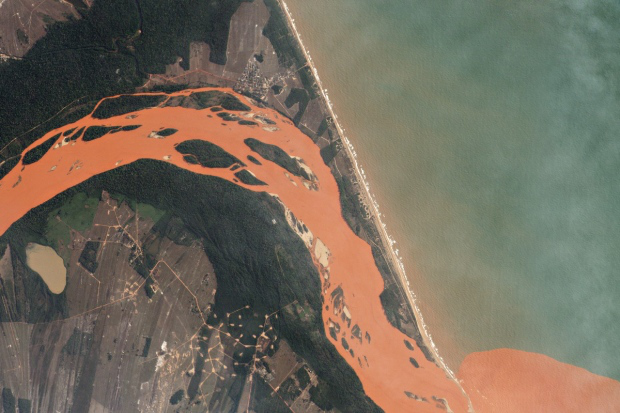

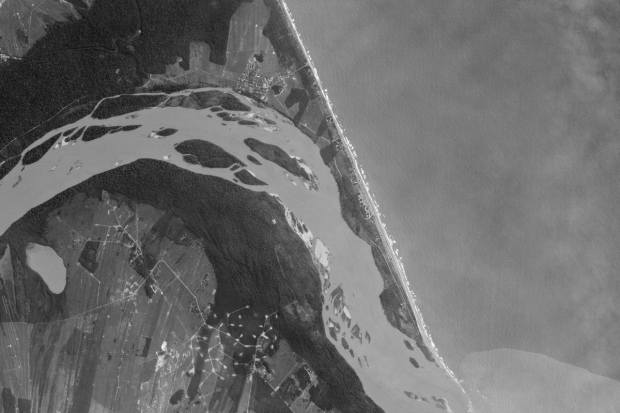

In [28]:
f = read_gray_image("images/rio-doce.jpg")
g = read_image("images/rio-doce.jpg")

display_image(g)
display_image(f)

Rio Doce:


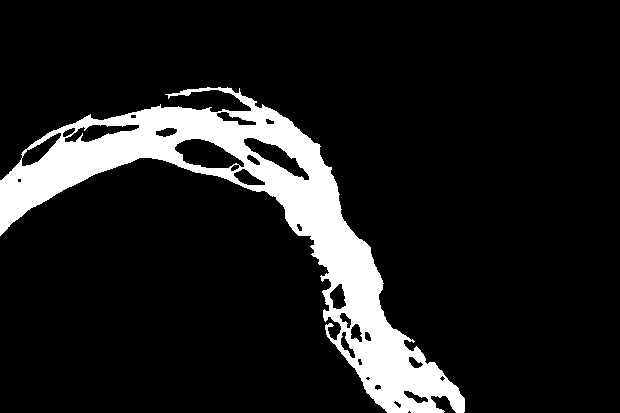

Área aproximada do Rio =  30257.0
Impacto dos rejeitos:


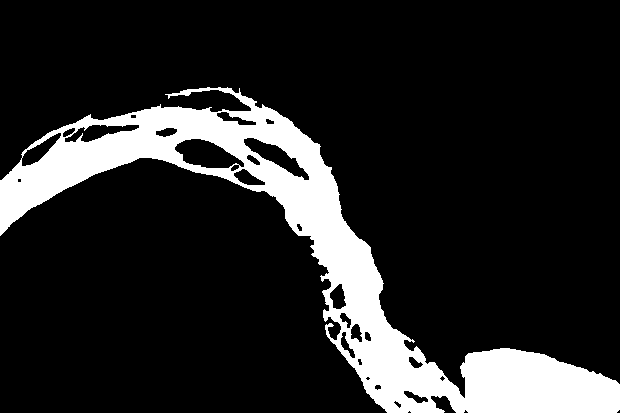

Área aproximada da região contaminada por rejeitos =  38589.0


In [29]:
f = gm.closing(f)
H, W = f.shape


# segmentação do Rio em 4 partes para realizar limiarizações locais

p1 = np.zeros((H, W))
p2 = np.zeros((H, W))
p3 = np.zeros((H, W))
p4 = np.zeros((H, W))

p1[70:int(H/2)+30, :int(W/2)] = f[70:int(H/2)+30, :int(W/2)]
p1 = p1 > 120
m1 = bm.opening(p1)
p1 = bm.inf_reconstruction(m1, p1)

p2[int(H/2)+30:, int(W/2): W-int(W/4)] = f[int(H/2)+30:, int(W/2):W-int(W/4)]
p2 = p2 > 155
m2 = np.zeros((p2.shape))
m2[int(H/2)+30:, W-3*int(W/8):W-int(W/4)] = f[int(H/2)+30:, W-3*int(W/8):W-int(W/4)]
m2 = m2 > 170
m2 = bm.dilation(m2, bm.create_structure_element_cross(2))
p2 = bm.sub_with_saturation(p2, m2)
p2 = bm.opening(p2)

p3[H-70:, W-int(W/4):] = f[H-70:, W-int(W/4):]
p3 = p3 > 145
p3 = bm.opening(p3, bm.create_structure_element_cross(3))


p4[135:int(H/2)+30, int(W/2):int(W/2)+50] = f[135:int(H/2)+30, int(W/2):int(W/2)+50]
p4 = p4 > 120
area4 = np.max(bm.calculate_connected_components_area(p4))
m4 = np.zeros((H, W))
p4 = bm.area_opening(p4, area4)

g1 = p1 + p2 + p4
g = g1 + p3

areard = np.max(bm.calculate_connected_components_area(g1))
g1 = bm.area_opening(g1, areard)
areacon = np.max(bm.calculate_connected_components_area(g))
g = bm.area_opening(g, areacon)


      
print("Rio Doce:")
display_binary_image(g1)
print("Área aproximada do Rio = ", areard)
print("Impacto dos rejeitos:")
display_binary_image(g)
print("Área aproximada da região contaminada por rejeitos = ", areacon)


## Esqueleto

<p>
    <strong>2)</strong> Foi desenvolvido um formato de arquivo para armazenar uma imagem no formato esqueleto morfológico, da seguinte forma:
    <ul> 
        <li> A primeira linha contém a largura e a altura da imagem separados por um espaço. </li>
        <li> 
            Da segunda linha em diante, cada linha representa um conjunto de pixels e o valor da função de quench 
            desses pixels. Os pixels são representados por suas posições na imagem (array flatten, imagine que dada 
            uma imagem em um array numpy, e então é utilizando a função flatten do numpy, veja 
            http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ndarray.flatten.html). Cada posição
            é separada por um espaço, a ultima posição é seguida por um ponto e vírgula e seguida pelo valor da 
            função quench.
        </li>
        <li> O elemento estrurante base utilizada para montar o esqueleto é a cruz</li>
    </ul>
</p>
<p>
    Abaixo segue um exemplo de arquivo de esqueleto ("images/circle.skel") de uma imagem da aproximação discreta de um circulo de raio 10 de uma imagem de tamanho 30x30:
</p>

<code>
30 30
403 406 493 496; 4
434 435 464 465; 5
</code>
<p>
    A imagem tem 30 pixels de largura e 30 pixels de altura, os pixels na posição 403, 406, 493, 496 tem valor 4 da função quench e os pixels 434, 435, 464, 465 tem valor 5 de função quench. Note que os pixels estão no formato flatten, ou seja, o pixel na posição 403 representa o ponto $(13,13) \in \mathbb{Z}^2$, o pixel na posição 493 representa o ponto $(16,13) \in \mathbb{Z}^2$, o pixel na posição 406 representa a posição $(13,16) \in \mathbb{Z}^2$ e assim por diante.
</p>
<p>
    Desenvolva uma função que lê (utilize as funções de manipulação de arquivo do Python, 
    https://docs.python.org/3/tutorial/inputoutput.html) um arquivo no formato
    descrito acima (funções de manipulação de strings podem ajudar,
    https://docs.python.org/3.5/library/stdtypes.html) e devolva a imagem binária reconstruída. 
    Utilize sua função para reconstruir a imagem armazenda em "images/image.skel" e exiba essa imagem.
</p>

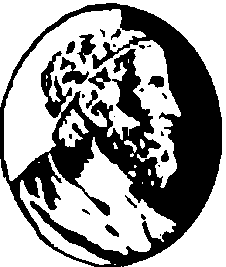

In [30]:
def skel_reconstruction(filename):
    with open(filename) as f:
        W, H = [int(i) for i in next(f).split()]
        g = np.zeros((W, H))
        pixels = []
        for line in f:
            line = line.replace(";", "")
            pixels.append([int(i) for i in line.split()])
            
    for i in range(len(pixels)):
        h = np.zeros((W, H))
        l = pixels[i]
        q = l[-1]
        for j in range(len(l) - 1):
            x = int(l[j] / H)
            y = int(l[j] % H)
            h[x, y] = 1
        if q > 1:
            h = bm.dilation(h, bm.create_structure_element_cross(), q-1)
        g += h
    
    return g.astype(bool)
        
    
    
display_binary_image(skel_reconstruction("images/circle.skel"))
display_binary_image(skel_reconstruction("images/image.skel"))